<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pyIMAGE</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>Image</b> analysis</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pyIMAGE.png"></td>
</tr>
</table>

----
# Image processing: Geophysical data -2-

In this notebook, we recover several geophysical data setsfrom the different channels of an image.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.interpolate
from scipy.ndimage import gaussian_filter
import PIL

----
## Reading image
We first read the image with `Image.read()` from the `PIL` library.

Then, the image object is converted to a 3D numpy array, using the `asarray()` function from `numpy`. 

<class 'numpy.ndarray'> uint8 3 (100, 200, 4)


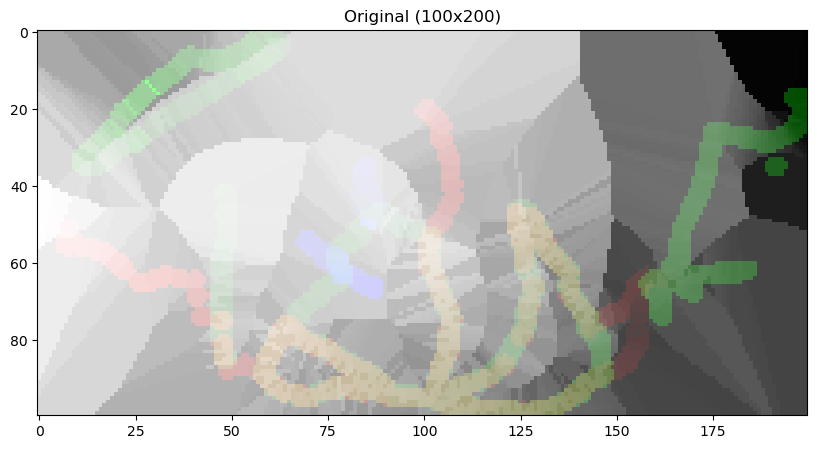

In [2]:
#image file name
infile='GP_Walpenreuth.png'

# load image with PIL library, convert to numpy array
image = PIL.Image.open(infile)
image_arr = np.asarray(image)
print (type(image_arr),image_arr.dtype,image_arr.ndim,image_arr.shape)

# show image
fig,axs = plt.subplots(1,1,figsize=(10,5))
axs.set_title('Original ('+str(image_arr.shape[0])+'x'+str(image_arr.shape[1])+')')
axs.imshow(image_arr)

We extract the different channels (red, green, blue, alpha) to separate 2D arrays, and plot them.

r min/max:  0 255
g min/max:  0 254
b min/max:  0 255
(100, 200)


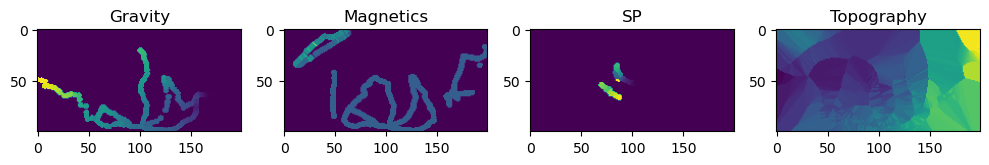

In [3]:
# show red, green, blue channels separately
image_r = image_arr[:,:,0]
image_g = image_arr[:,:,1]
image_b = image_arr[:,:,2]
image_a = image_arr[:,:,3]
print('r min/max: ',image_r.min(),image_r.max())
print('g min/max: ',image_g.min(),image_g.max())
print('b min/max: ',image_b.min(),image_b.max())
print(image_r.shape)

fig,axs = plt.subplots(1,4,figsize=(10,5))
axs[0].set_title('Gravity')
axs[1].set_title('Magnetics')
axs[2].set_title('SP')
axs[3].set_title('Topography')
axs[0].imshow(image_r,vmin=0,vmax=255)
axs[1].imshow(image_g,vmin=0,vmax=255)
axs[2].imshow(image_b,vmin=0,vmax=255)
axs[3].imshow(image_a,vmin=0,vmax=255)
plt.tight_layout()

----
## Scaling the data

**Missing:** Read exif data

We assign the scaling ranges for coordinates, topography, and the geophysical data sets.

In [4]:
eastmin,eastmax = [699759.63,703156.97]
northmin,northmax=[5555334.25,5557058.99]
gravmin,gravmax = [-0.36,10.58]

magmin,magmax = [-2575.16,6060.41]
spmin,spmax = [-1.0,54.0]
topomin,topomax = [615.07,806.0]

----
## Recover data

We recover the data sets in two steps:

- Create 2D array for easting, northing, topography, gravity, magnetics, and self-potential,
based on the dimensions for the image. **Note:** We sort the **northing** coorinates from bottom to top
to avoid the flipping again...

In [5]:
east  = np.zeros([image_r.shape[0],image_r.shape[1]])
north = np.zeros([image_r.shape[0],image_r.shape[1]])
grav  = np.zeros([image_r.shape[0],image_r.shape[1]])
mag   = np.zeros([image_r.shape[0],image_r.shape[1]])
sp    = np.zeros([image_r.shape[0],image_r.shape[1]])
topo  = np.zeros([image_r.shape[0],image_r.shape[1]])

nnorth = image_r.shape[0]
neast  = image_r.shape[1]
for i in range(nnorth):
    for j in range(neast):
        north[i,j] = northmin + (northmax-northmin)*float(nnorth-i)/float(nnorth)
        east[i,j] = eastmin + (eastmax-eastmin)*float(j)/float(neast)

In [6]:
print(east.min(),east.max())
print(north.min(),north.max())

699759.63 703139.9833
5555351.4974 5557058.99


- We then use the channel data scaled between [0,255] and rescale them to the data range,
and setting the value `0` to `np.nan`, as there we have no data.

In [7]:
grav = np.where(image_r>0,gravmin + (gravmax-gravmin)*image_r/255,np.nan)
mag  = np.where(image_g>0,magmin + (magmax-magmin)*image_g/255,np.nan)
sp  = np.where(image_b>0,spmin + (spmax-spmin)*image_b/255,np.nan)
topo  = np.where(image_a>0,topomin + (topomax-topomin)*image_a/255,np.nan)

Finally plot the recovered data sets.

**Note:** We used the filter `gaussian_filter` from the `scipy.interpolate` package to smooth
the topography contours.

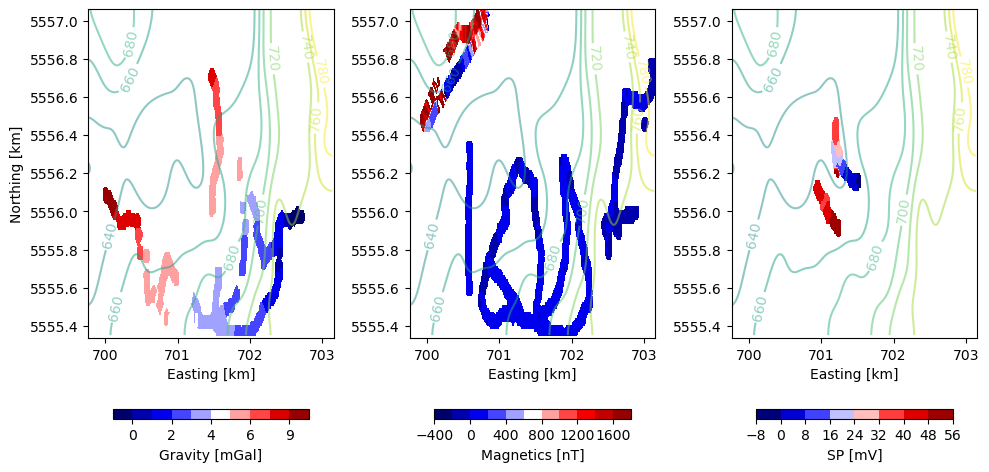

In [8]:
scale=1000
sigma=5
fig,axs = plt.subplots(1,3,figsize=(10,5))
# gravity
axs[0].set_xlabel('Easting [km]')
axs[0].set_ylabel('Northing [km]')
axs[0].set_xlim([eastmin/1000,eastmax/1000])
axs[0].set_ylim([northmin/1000,northmax/1000])
cbar1=axs[0].contourf(east/scale,north/scale,grav,
                      levels=[-1,0,1,2,3,4,5,6,7,9,10],cmap='seismic')
cont1=axs[0].contour(east/scale,north/scale,gaussian_filter(topo,sigma),alpha=0.5,
                     levels=[x for x in np.arange(500,800,20)])
axs[0].clabel(cont1, cont1.levels, inline=True)
plt.colorbar(cbar1,location='bottom',shrink=0.8,label='Gravity [mGal]')

# magnetics
axs[1].set_xlabel('Easting [km]')
axs[1].set_xlim([eastmin/1000,eastmax/1000])
axs[1].set_ylim([northmin/1000,northmax/1000])
cbar2=axs[1].contourf(east/scale,north/scale,mag,
                      levels=[x for x in np.arange(-400,2000,200)],cmap='seismic')
cont1=axs[1].contour(east/scale,north/scale,gaussian_filter(topo,sigma),alpha=0.5,
                                                            levels=[x for x in np.arange(500,800,20)])
axs[1].clabel(cont1, cont1.levels, inline=True)
plt.colorbar(cbar2,location='bottom',shrink=0.8,label='Magnetics [nT]')

# self-potential
axs[2].set_xlabel('Easting [km]')
axs[2].set_xlim([eastmin/1000,eastmax/1000])
axs[2].set_ylim([northmin/1000,northmax/1000])
cbar3=axs[2].contourf(east/scale,north/scale,sp,cmap='seismic')
cont1=axs[2].contour(east/scale,north/scale,gaussian_filter(topo,sigma),alpha=0.5,
                                                            levels=[x for x in np.arange(500,800,20)])
axs[2].clabel(cont1, cont1.levels, inline=True)
plt.colorbar(cbar3,location='bottom',shrink=0.8,label='SP [mV]')
plt.tight_layout()

----